# CIGALE Luminosity Functions

### Import and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM

F_comp = 80 # flux completeness %
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(6, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

### Load Data

In [2]:
# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN3.csv', index_col='Seq')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN3.csv', index_col='Seq')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN3.csv', index_col='Seq')

# All CIGALE sources
oCDFS = pd.read_csv('../DATA/Ollie Data/CDFS/results.txt', delim_whitespace=True, index_col='id')
oCOSMOS = pd.read_csv('../DATA/Ollie Data/COSMOS/results.txt', delim_whitespace=True, index_col='id')
oUDS = pd.read_csv('../DATA/Ollie Data/UDS/results.txt', delim_whitespace=True, index_col='id')

### Mask & Combine Data

Must be done from individual fields, otherwise the data masks won't align. This is because Ollie dropped failed ID's instead of assigning a bad value.

In [3]:
def mask_data(zfourge, cigale, survey_name):
    # Use Mask
    use_mask = zfourge['Use'] == 1
    zfourge = zfourge.loc[use_mask]
    cigale = cigale.loc[use_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Use=1: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Use=1: {len(cigale)}')

    # LIR Mask
    lir_mask = zfourge['LIR'] > 0 
    zfourge = zfourge.loc[lir_mask]
    cigale = cigale.loc[lir_mask]
    # print(f'Number of ZFOURGE {survey_name} sources LIR>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources LIR>0: {len(cigale)}')

    # F24 Mask
    F24_mask = zfourge['F24'] > 0 
    zfourge = zfourge.loc[F24_mask]
    cigale = cigale.loc[F24_mask]
    # print(f'Number of ZFOURGE {survey_name} sources F24>0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources F24>0: {len(cigale)}')

    # Redshift Mask
    red_mask = (zfourge['zpk'] >= redshift_bins[0][0]) & (zfourge['zpk'] <= redshift_bins[-1][1]) 
    zfourge = zfourge.loc[red_mask]
    cigale = cigale.loc[red_mask]
    # print(f'Number of ZFOURGE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(cigale)}')

    # AGN Mask
    agn_mask = (zfourge['irAGN'] == 1) | (zfourge['radAGN'] == 1) | (zfourge['xAGN'] == 1) 
    zfourge = zfourge.loc[~agn_mask]
    cigale = cigale.loc[~agn_mask]
    # print(f'Number of ZFOURGE {survey_name} sources AGN=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources AGN=0: {len(cigale)}')
    
    # Nan Mask
    nan_mask = ~np.isnan(cigale['bayes.universe.luminosity_distance'])
    zfourge = zfourge.loc[nan_mask]
    cigale = cigale.loc[nan_mask]
    # print(f'Number of ZFOURGE {survey_name} sources Nan=0: {len(zfourge)}')
    print(f'Number of CIGALE {survey_name} sources Nan=0: {len(cigale)}')
    
    # Common sources
    common_sources = zfourge.index.intersection(cigale.index)
    zfourge = zfourge.loc[common_sources]
    cigale = cigale.loc[common_sources]
    print(f'Number of common sources: {len(zfourge)}')
    print('\n')
    return zfourge, cigale

print(f'Total number of sources CIGALE: {len(oCDFS) + len(oCOSMOS) + len(oUDS)} \n')
CDFS_m, oCDFS_m = mask_data(CDFS, oCDFS, 'CDFS')
COSMOS_m, oCOSMOS_m = mask_data(COSMOS, oCOSMOS, 'COSMOS')
UDS_m, oUDS_m = mask_data(UDS, oUDS, 'UDS')

# All ZFOURGE sources
df = pd.concat([CDFS_m, COSMOS_m, UDS_m], ignore_index=True)
odf = pd.concat([oCDFS_m, oCOSMOS_m, oUDS_m], ignore_index=True)
print(f'Number of ZFOURGE sources: {len(df)}')
print(f'Number of CIGALE sources: {len(odf)}')

Total number of sources CIGALE: 73758 

Number of CIGALE CDFS sources Use=1: 13299
Number of CIGALE CDFS sources LIR>0: 8486
Number of CIGALE CDFS sources F24>0: 8486
Number of CIGALE CDFS sources 0.0 <= z <= 6.0: 8469
Number of CIGALE CDFS sources AGN=0: 8193
Number of CIGALE CDFS sources Nan=0: 8187
Number of common sources: 8187


Number of CIGALE COSMOS sources Use=1: 12901
Number of CIGALE COSMOS sources LIR>0: 7954
Number of CIGALE COSMOS sources F24>0: 7954
Number of CIGALE COSMOS sources 0.0 <= z <= 6.0: 7947
Number of CIGALE COSMOS sources AGN=0: 7815
Number of CIGALE COSMOS sources Nan=0: 7815
Number of common sources: 7815


Number of CIGALE UDS sources Use=1: 11447
Number of CIGALE UDS sources LIR>0: 6557
Number of CIGALE UDS sources F24>0: 6557
Number of CIGALE UDS sources 0.0 <= z <= 6.0: 6551
Number of CIGALE UDS sources AGN=0: 6436
Number of CIGALE UDS sources Nan=0: 6436
Number of common sources: 6436


Number of ZFOURGE sources: 22438
Number of CIGALE sources: 22438


### Sanity Check

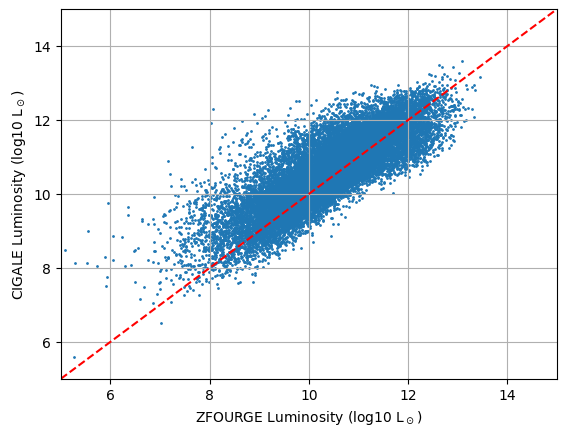

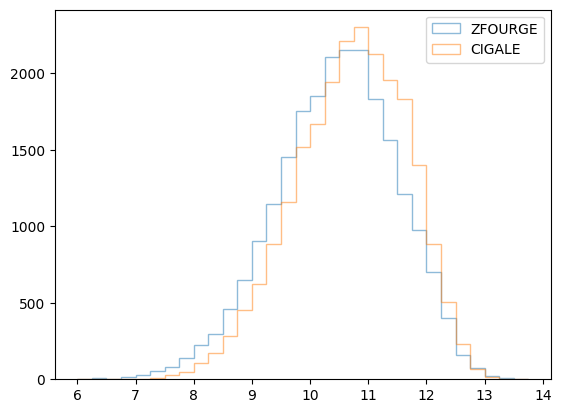

In [4]:
zf_lum = df['LIR'] # Solar Luminosity
cg_lum = (odf['bayes.stellar.lum'] + odf['bayes.agn.luminosity'] + odf['bayes.dust.luminosity'])/(3.83*10**26) # Solar Luminosity

x = np.linspace(5, 15, 100)

plt.scatter(np.log10(zf_lum), np.log10(cg_lum), s=1)
plt.plot(x, x, linestyle='--', color='red')
plt.ylabel('CIGALE Luminosity (log10 L$_\odot$)')
plt.xlabel('ZFOURGE Luminosity (log10 L$_\odot$)')
plt.grid()
plt.xlim(5, 15)
plt.ylim(5, 15)
plt.show()

plt.hist(np.log10(zf_lum), bins=lum_bin_edges, alpha=0.5, label='ZFOURGE', histtype='step')
plt.hist(np.log10(cg_lum), bins=lum_bin_edges, alpha=0.5, label='CIGALE', histtype='step')
plt.legend()
plt.show()

### Total Luminosity

In [5]:
old_luminosity = (odf['bayes.stellar.lum'] + odf['bayes.dust.luminosity'] + odf['bayes.agn.luminosity'])/(3.83*10**26) # Solar Luminosity

### Stellar Luminosity

In [ ]:
old_luminosity = (odf['bayes.stellar.lum'] + odf['bayes.dust.luminosity'])/(3.83*10**26) # Solar Luminosity

### AGN Luminosity

In [102]:
old_luminosity = odf['bayes.agn.luminosity']/(3.83*10**26) # Solar Luminosity

### Flux Limits

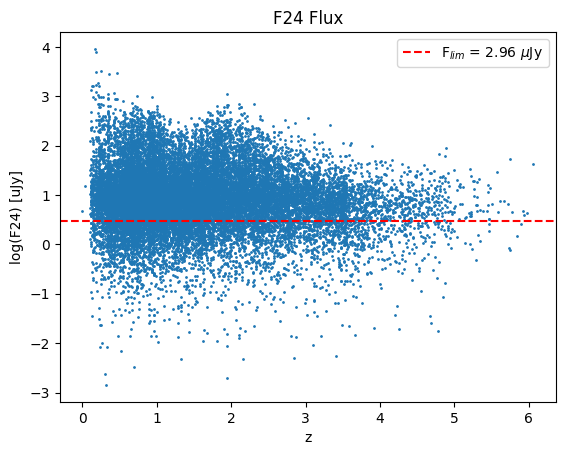

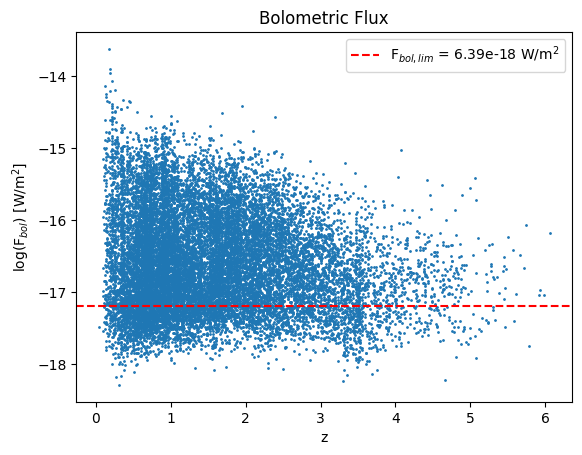

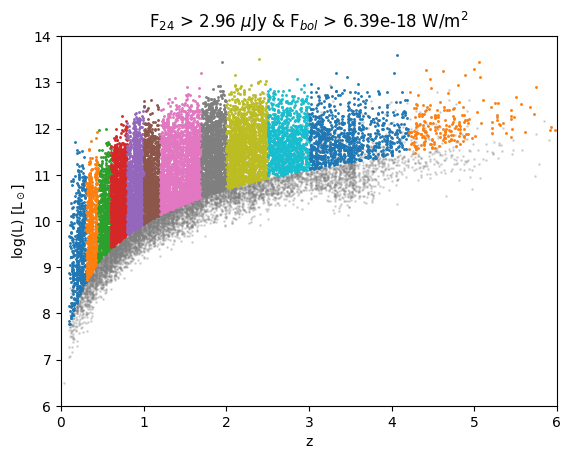

Number of galaxies previous total: 22438
Number of galaxies F > 2.96 uJy: 17952
Number of galaxies F24 & F_bol > 6.39e-18 W/m^2: 14361


In [7]:
old_z = odf['bayes.universe.redshift'].values.copy() # redshift

""" Both F24 and Bolo Flux """
# F24 Flux
F24 = df['F24'].values.copy() # mJy
F24 *= 10**3 # uJy
F_lim = np.percentile(F24, 100-F_comp) # % of the data above perc
F_lim = 2.96 # % of the data above perc
F24_mask = F24 > F_lim
plt.scatter(old_z, np.log10(F24), s=1)
plt.axhline(np.log10(F_lim), color='r', linestyle='--', label=f"F$_{{lim}}$ = {np.round(F_lim,2)} $\mu$Jy")
plt.title('F24 Flux')
plt.ylabel('log(F24) [uJy]')
plt.xlabel('z')
plt.legend()
plt.show()

# Bolo Flux
d_L = cosmo.luminosity_distance(old_z).to('m').value
F_bol = (old_luminosity*(3.83*10**26)) / (4*np.pi*d_L**2) # W/m^2
F_bol_lim = np.percentile(F_bol[F24_mask], 100-F_comp) # % of the data above perc
# F_bol_lim = 6.39e-18 # W/m^2
F_bol_mask = F_bol > F_bol_lim
plt.scatter(old_z[F24_mask], np.log10(F_bol[F24_mask]), s=1)
plt.axhline(np.log10(F_bol_lim), color='r', linestyle='--', label=f"F$_{{bol,lim}}$ = {F_bol_lim:.2e} W/m$^2$")
plt.title('Bolometric Flux')
plt.ylabel('log(F$_{bol}$) [W/m$^2$]')
plt.xlabel('z')
plt.legend()
plt.show()

# # Varying Bolo Flux
# d_L = cosmo.luminosity_distance(old_z).to('m').value
# F_bol = (old_luminosity*(3.83*10**26)) / (4*np.pi*d_L**2) # W/m^2
# F_bol_mask = np.zeros(len(F_bol), dtype=bool)
# for z_start, z_end in redshift_bins:
#     mask_z = (old_z > z_start) & (old_z <= z_end)
#     F_bol_lim = np.percentile(F_bol[F24_mask & mask_z], 100-F_comp) # % of the data above perc
#     F_bol_mask[mask_z] = F_bol[mask_z] > F_bol_lim
#     plt.hlines(np.log10(F_bol_lim), color='r', linestyle='--', label=f"F$_{{bol,lim}}$ = {F_bol_lim:.2e} W/m$^2$", xmin=z_start, xmax=z_end)
# print(len(F_bol_mask), sum(F_bol_mask))
# plt.scatter(old_z[F24_mask], np.log10(F_bol[F24_mask]), s=1)
# plt.title('Bolometric Flux')
# plt.ylabel('log(F$_{bol}$) [W/m$^2$]')
# plt.xlabel('z')
# plt.legend(bbox_to_anchor=(1, 1))
# plt.show()

plt.scatter(old_z, np.log10(old_luminosity), s=1, color='grey', alpha=0.25)
for z_start, z_end in redshift_bins:
    mask_z = (old_z > z_start) & (old_z <= z_end)
    plt.scatter(old_z[F24_mask & F_bol_mask & mask_z], np.log10(old_luminosity[F24_mask & F_bol_mask & mask_z]), s=1)
plt.title(f'F$_{{24}}$ > {np.round(F_lim,2)} $\mu$Jy & F$_{{bol}}$ > {F_bol_lim:.2e} W/m$^2$')
plt.ylabel('log(L) [L$_\odot$]')
plt.xlabel('z')
plt.ylim(6, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.show()

print(f'Number of galaxies previous total: {len(old_z)}')
print(f'Number of galaxies F > {np.round(F_lim,2)} uJy: {len(old_z[F24_mask])}')
print(f'Number of galaxies F24 & F_bol > {F_bol_lim:.2e} W/m^2: {len(old_z[F24_mask & F_bol_mask])}')

z = old_z[F24_mask & F_bol_mask]
luminosity = old_luminosity[F24_mask & F_bol_mask]

### Data Correcting

1. Exclude sources with flux less than the minimum
2. Exclude luminosity bins less than the min count
3. Exclude luminosity bins on the faint side of the turn over point

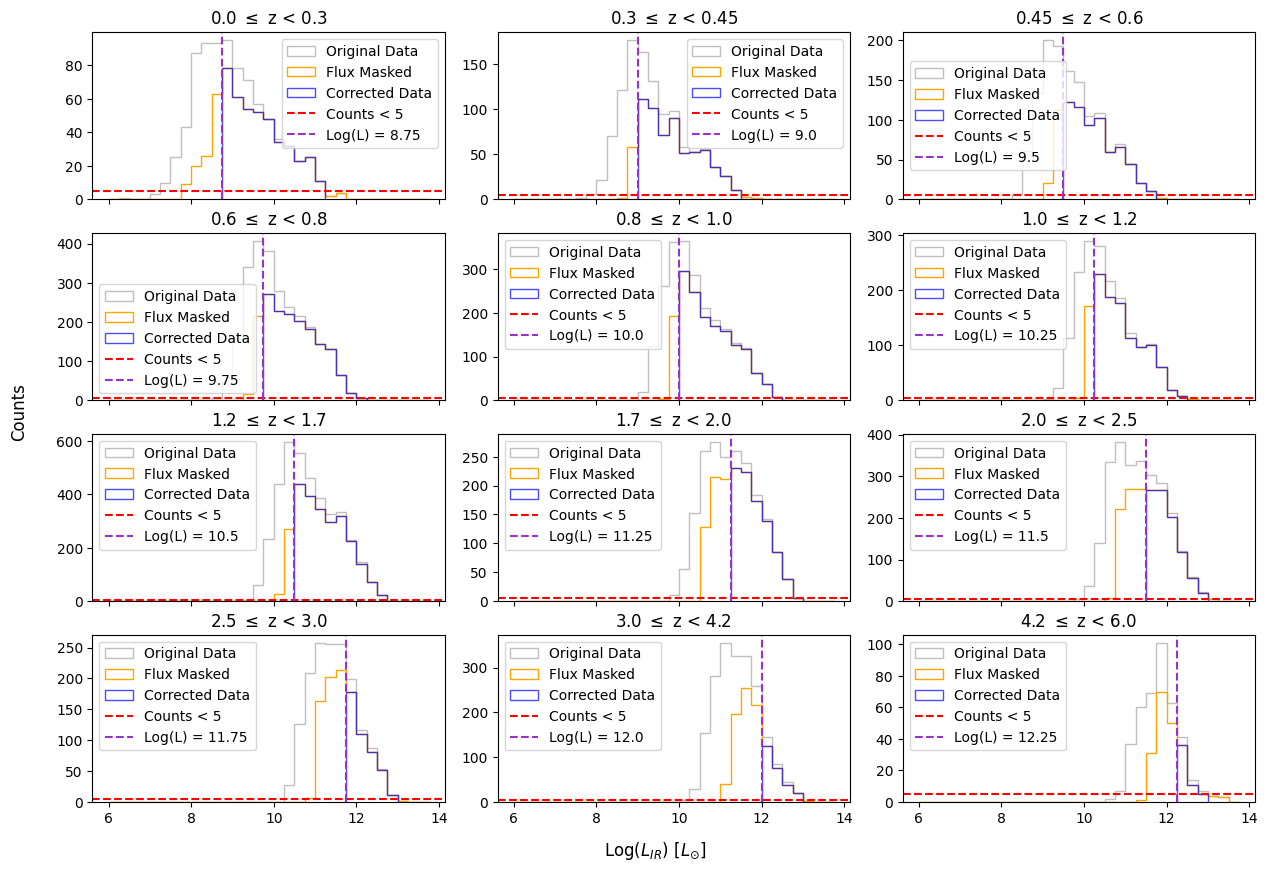

In [8]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
min_l = []
# min_l = np.load('fits/ZFOURGE_ALL.npz', allow_pickle=True)['m']
bin_edges = []

# for ax, (z_start, z_end), tp in zip(axes.flatten(), redshift_bins, min_l):
for ax, (z_start, z_end) in zip(axes.flatten(), redshift_bins):
    mask_z = (z > z_start) & (z <= z_end)
        
    # Bin the corrected (masked) data
    c, b = np.histogram(np.log10(luminosity[mask_z]), bins=lum_bin_edges)
    centers = (b[:-1] + b[1:]) / 2 # luminosity bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    # Mask faint end bins less than the turnover point
    peak_index = np.argmax(c)
    turnover_point = b[peak_index]
    if np.any(turnover_point <= min_l): # if the turnover point is less than or equal to the previous turnover points
        turnover_point = max(min_l)+np.diff(b)[0] # set the turnover point to the maximum + bin width
    b_mask = b[1:] >= turnover_point
    # b_mask = b[1:] >= tp

    # Apply the masks
    b = b[1:][c_mask & b_mask]
    centers = centers[c_mask & b_mask]
    c = c[c_mask & b_mask]
        
    # Plot the data
    ax.hist(np.log10(old_luminosity[(old_z > z_start) & (old_z <= z_end)]), bins=lum_bin_edges, histtype='step', color='grey', label='Original Data', alpha=0.5)
    ax.hist(np.log10(luminosity[mask_z]), bins=lum_bin_edges, histtype='step', color='orange', label='Flux Masked')
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(turnover_point, color='darkorchid', linestyle='--', label=f'Log(L) = {turnover_point}')
    # ax.axvline(tp, color='lime', linestyle='--', label=f'Log(L) = {tp}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    ax.legend()
    
    # Save data
    min_l.append(turnover_point)
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
plt.show()    

### Calculate Maximum Volume

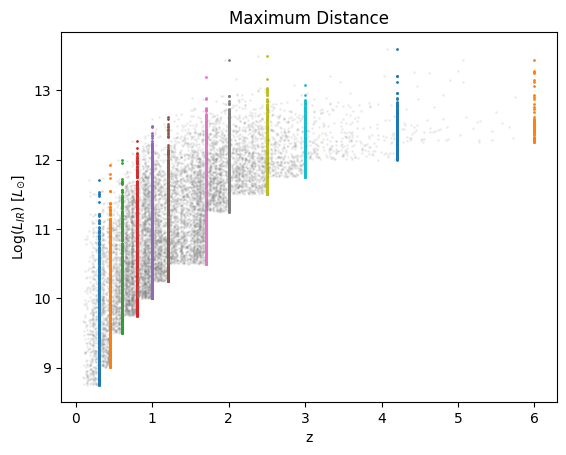

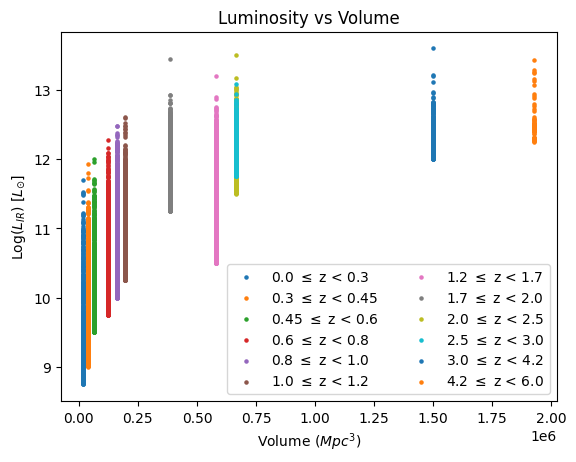

In [9]:
all_data = []

for (z_start, z_end), lmin in zip(redshift_bins, min_l):
    mask_z = (z > z_start) & (z <= z_end)
    
    # Data bin
    lum_bin = np.log10(luminosity[mask_z])
    z_bin = z[mask_z]
    
    # Mask the faint end
    mask_l = lum_bin >= lmin
    lum_bin = lum_bin[mask_l]
    z_bin = z_bin[mask_l]
    
    # Maximum distance of all sources is the end of the redshift bin
    zmaxs = z_bin.copy()
    zmaxs[:] = z_end
    
    # Comoving distance of the minimum and maximum redshifts
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmaxs = cosmo.comoving_distance(zmaxs).value # Mpc
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])
    plt.scatter(z_bin, lum_bin, s=1, color='grey', alpha=0.1)
    plt.scatter(zmaxs, lum_bin, s=1)
plt.title('Maximum Distance')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.xlabel('z')
plt.show()
     
plt.title('Luminosity vs Volume')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend(loc='lower right', ncols=2)
plt.show()

### Luminosity Function

0.0 <= z < 0.3, [8.875, 9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125]
0.3 <= z < 0.45, [9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375]
0.45 <= z < 0.6, [9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625]
0.6 <= z < 0.8, [9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125]
0.8 <= z < 1.0, [10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375]
1.0 <= z < 1.2, [10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375]
1.2 <= z < 1.7, [10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625]
1.7 <= z < 2.0, [11.375, 11.625, 11.875, 12.125, 12.375, 12.625, 12.875]
2.0 <= z < 2.5, [11.625, 11.875, 12.125, 12.375, 12.625, 12.875]
2.5 <= z < 3.0, [11.875, 12.125, 12.375, 12.625, 12.875]
3.0 <= z < 4.2, [12.125, 12.375, 12.625, 12.875]
4.2 <= z < 6.0, [12.375, 12.625, 12.875]


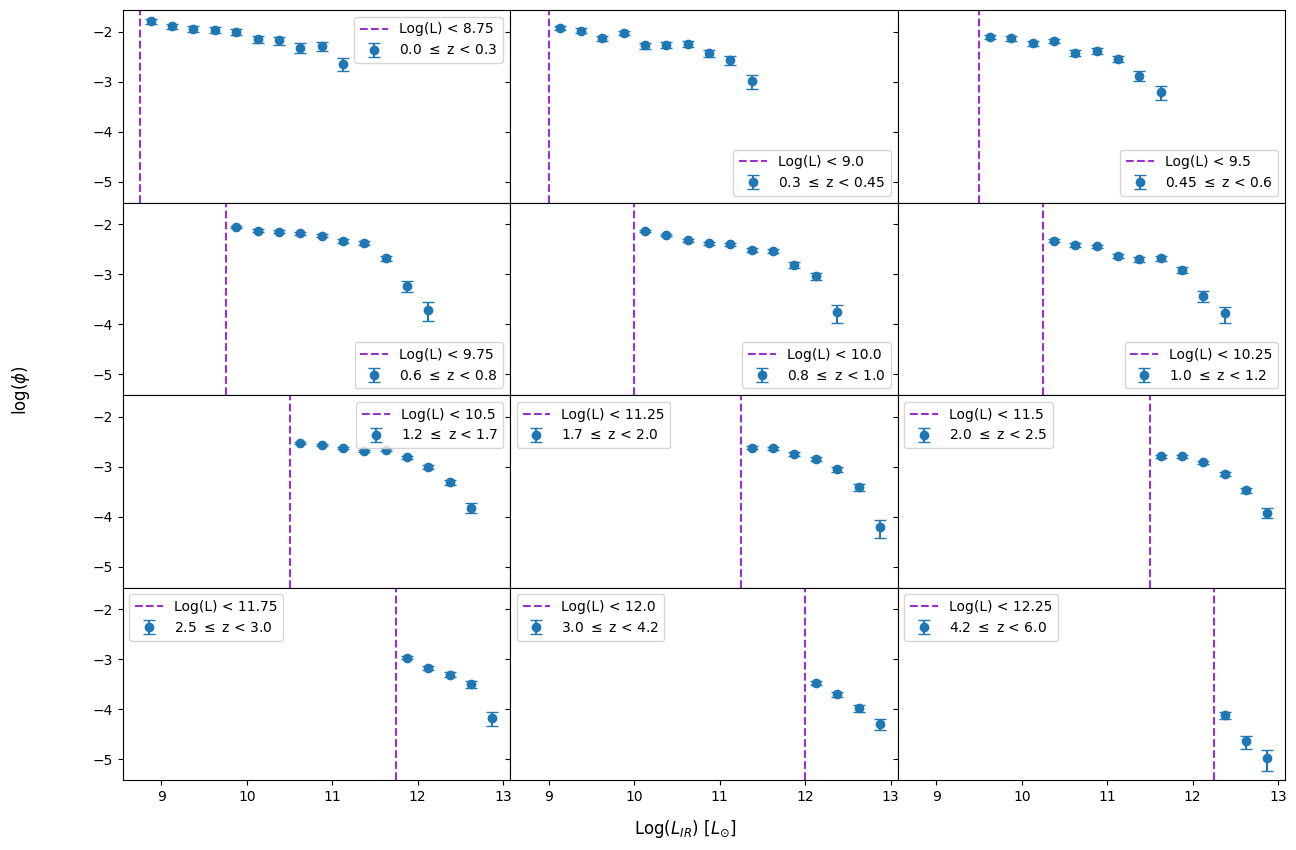

In [10]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin in zip(all_data, bin_edges):
    
    if len(bin) <= 1:
        lum_centers.append(np.array([]))
        phi.append(np.array([]))
        phi_e.append(np.array([]))
        continue
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_ls in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), min_l):
    print(f'{z_start} <= z < {z_end}, {(lum)}')
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(min_ls, color='darkorchid', linestyle='--', label=f'Log(L) < {round(min_ls, 2)}')
    ax.legend()
    
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

### Schechter Function

0.0 <= z < 0.3 Function fit:
Log L_star = 10.18 +/- 0.0
Log phi_star = -2.85 +/- 0.03
Alpha = 1.2


0.3 <= z < 0.45 Function fit:
Log L_star = 10.68 +/- 0.0
Log phi_star = -2.95 +/- 0.02
Alpha = 1.2


0.45 <= z < 0.6 Function fit:
Log L_star = 10.68 +/- 0.0
Log phi_star = -2.91 +/- 0.03
Alpha = 1.2


0.6 <= z < 0.8 Function fit:
Log L_star = 10.5 +/- 0.17
Log phi_star = -2.63 +/- 0.05
Alpha = 1.2


0.8 <= z < 1.0 Function fit:
Log L_star = 10.32 +/- 0.14
Log phi_star = -2.49 +/- 0.06
Alpha = 1.2


1.0 <= z < 1.2 Function fit:
Log L_star = 10.44 +/- 0.05
Log phi_star = -2.59 +/- 0.03
Alpha = 1.2


1.2 <= z < 1.7 Function fit:
Log L_star = 10.65 +/- 0.05
Log phi_star = -2.54 +/- 0.03
Alpha = 1.2


1.7 <= z < 2.0 Function fit:
Log L_star = 11.06 +/- 0.07
Log phi_star = -2.63 +/- 0.04
Alpha = 1.2


2.0 <= z < 2.5 Function fit:
Log L_star = 11.26 +/- 0.05
Log phi_star = -2.74 +/- 0.03
Alpha = 1.2


2.5 <= z < 3.0 Function fit:
Log L_star = 11.57 +/- 0.0
Log phi_star = -2.95 +/- 0.01
Alpha =

C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\2090208922.py:53: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\2090208922.py:55: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_down)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\2090208922.py:56: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_up)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\2090208922.py:45: RuntimeWarning: invalid value encountered in log10
  print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')


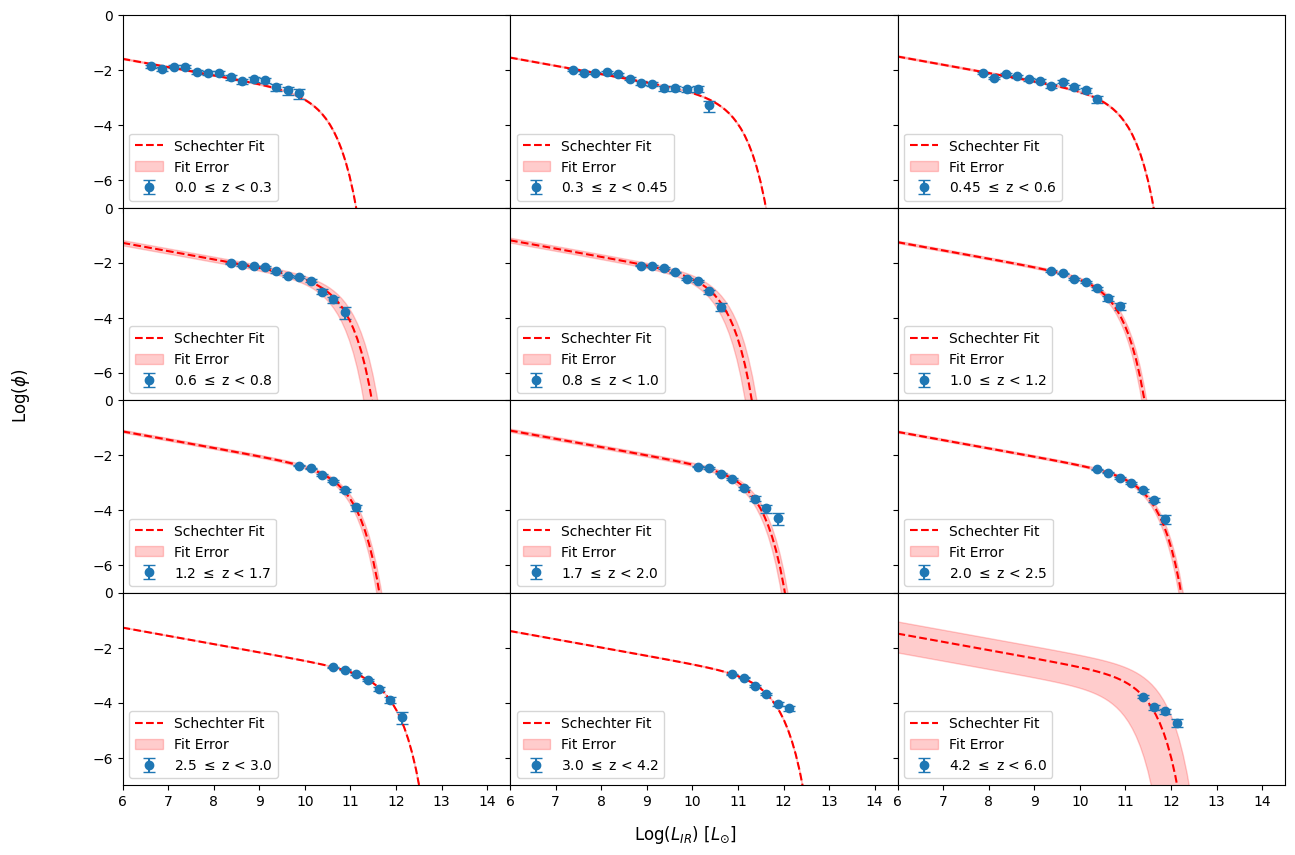

In [129]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []
schechter_funcs = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append(np.array([None, None]))
        schecter_errors.append(np.array([None, None]))
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        schecter_params.append(params)
        schecter_errors.append(perr)
        schechter_funcs.append(schechter_luminosity)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        schecter_params.append(np.array([None, None]))
        schecter_errors.append(np.array([None, None]))
        schechter_funcs.append(None)
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        schecter_params.append(np.array([None, None]))
        schecter_errors.append(np.array([None, None]))
        schechter_funcs.append(None)
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.2')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(6, 14.5, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(6, 14.5)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Function

0.0 <= z < 0.3 Function fit:
Log L_star = 9.96 +/- 0.0
Log phi_star = -2.78 +/- 0.03
Alpha = 1.3
Sigma = 0.9


0.3 <= z < 0.45 Function fit:
Log L_star = 10.0 +/- nan
Log phi_star = -2.75 +/- 0.38
Alpha = 1.3
Sigma = 0.9


0.45 <= z < 0.6 Function fit:
Log L_star = 10.25 +/- 0.0
Log phi_star = -2.79 +/- 0.03
Alpha = 1.3
Sigma = 0.9


0.6 <= z < 0.8 Function fit:
Log L_star = 9.57 +/- 0.17
Log phi_star = -2.36 +/- 0.05
Alpha = 1.3
Sigma = 0.9


0.8 <= z < 1.0 Function fit:
Log L_star = 9.41 +/- 0.15
Log phi_star = -2.23 +/- 0.06
Alpha = 1.3
Sigma = 0.9


1.0 <= z < 1.2 Function fit:
Log L_star = 9.51 +/- 0.05
Log phi_star = -2.32 +/- 0.03
Alpha = 1.3
Sigma = 0.9


1.2 <= z < 1.7 Function fit:
Log L_star = 9.71 +/- 0.09
Log phi_star = -2.26 +/- 0.05
Alpha = 1.3
Sigma = 0.9


1.7 <= z < 2.0 Function fit:
Log L_star = 10.15 +/- 0.1
Log phi_star = -2.37 +/- 0.05
Alpha = 1.3
Sigma = 0.9


2.0 <= z < 2.5 Function fit:
Log L_star = 10.31 +/- 0.03
Log phi_star = -2.45 +/- 0.02
Alpha = 1.3
Sigma

C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\3747050798.py:52: RuntimeWarning: invalid value encountered in log10
  print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')


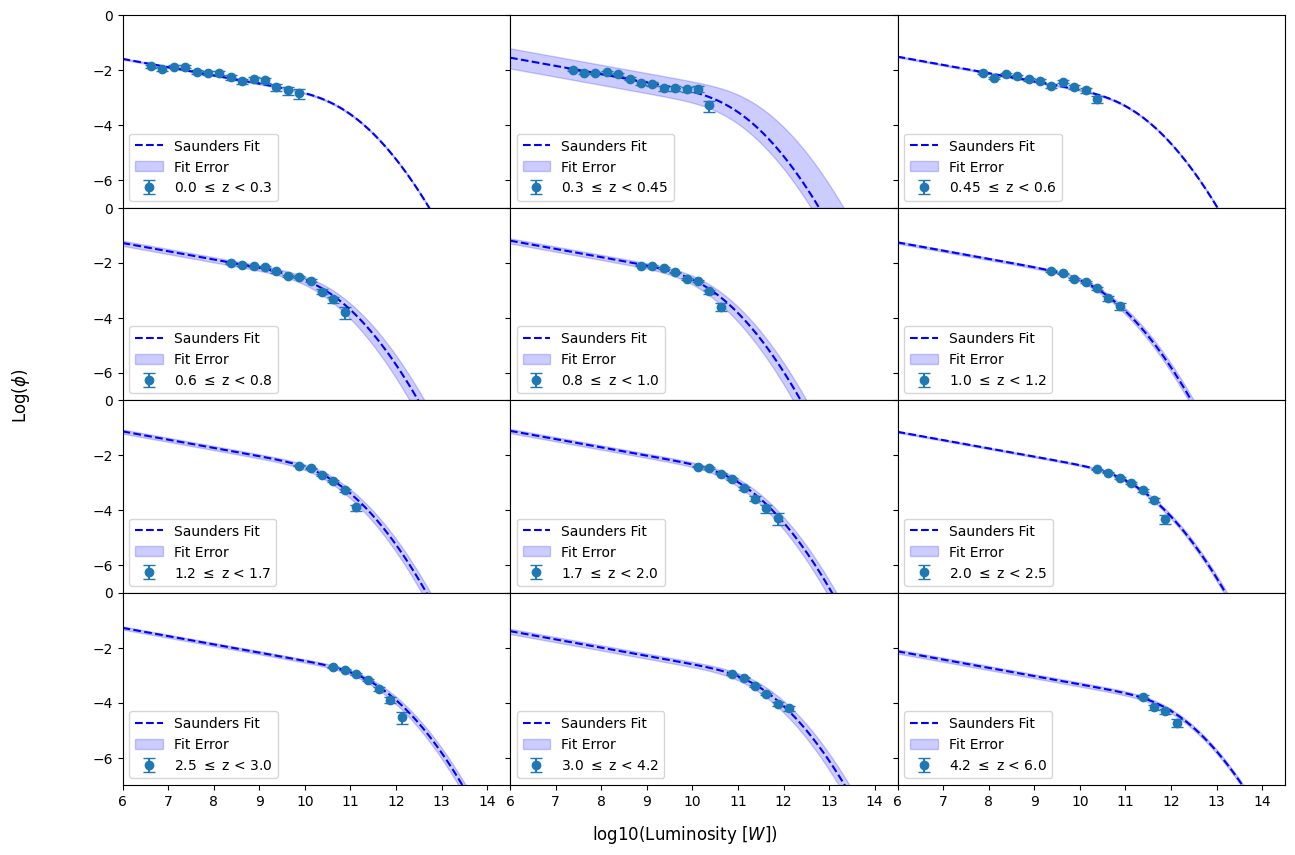

In [135]:
def saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)

def early_saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
saunder_funcs = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append(np.array([None, None]))
        saunder_error.append(np.array([None, None]))
        continue
    
    if z_start in [0.0, 0.3, 0.45]:
        f = early_saunders_luminosity
    else:
        f = saunders_luminosity
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(f, lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        saunder_params.append(params)
        saunder_error.append(perr)
        saunder_funcs.append(f)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        saunder_params.append(np.array([None, None]))
        saunder_error.append(np.array([None, None]))
        saunder_funcs.append(None)
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        saunder_params.append(np.array([None, None]))
        saunder_error.append(np.array([None, None]))
        saunder_funcs.append(None)
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.3')
    print(f'Sigma = 0.9')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(6, 14.5, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(f(long_lum, *params)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(f(long_lum, *p_down)), 
        np.log10(f(long_lum, *p_up)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(6, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter & Saunders

C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\3983094633.py:8: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='red', label='Schechter Fit' if i == 0 else "", linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\3983094633.py:10: RuntimeWarning: divide by zero encountered in log10
  np.log10(func(long_lum, *p_down)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\3983094633.py:11: RuntimeWarning: divide by zero encountered in log10
  np.log10(func(long_lum, *p_up)),


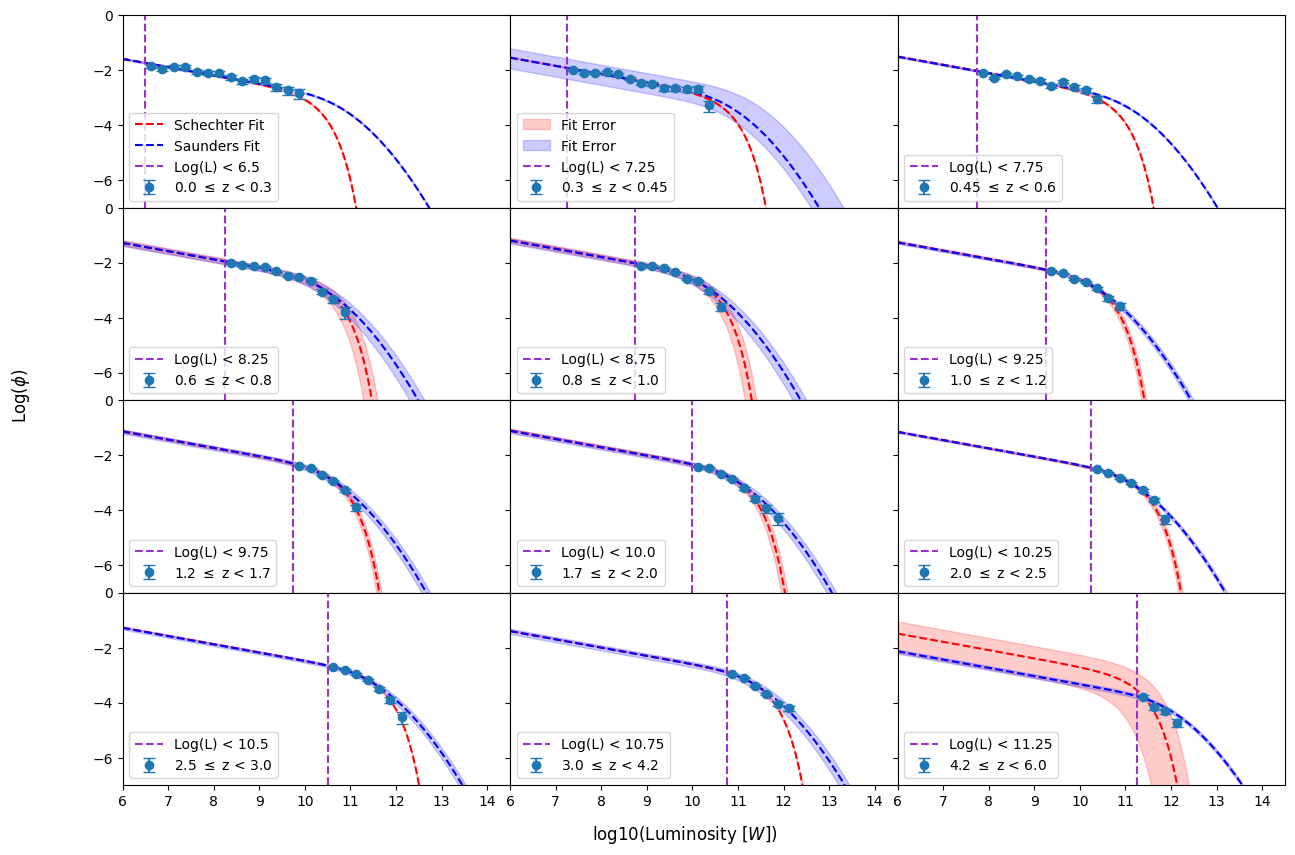

In [136]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# Schechter Function
for i, (ax, func, params, perr) in enumerate(zip(axes.flatten(), schechter_funcs, schecter_params, schecter_errors)):
    long_lum = np.logspace(6, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='red', label='Schechter Fit' if i == 0 else "", linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(func(long_lum, *p_down)),
        np.log10(func(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error' if i == 1 else "")

# Saunders Function
for i, (ax, func, params, perr) in enumerate(zip(axes.flatten(), saunder_funcs, saunder_params, saunder_error)):
    long_lum = np.logspace(6, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='blue', label='Saunders Fit' if i == 0 else "", linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(func(long_lum, *p_down)),
        np.log10(func(long_lum, *p_up)),
        color='blue', alpha=0.2, label='Fit Error' if i == 1 else "")

# Luminosity Function
for (z_start, z_end), lum, p, e, ax, lmin in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), min_l):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(lmin, color='darkorchid', linestyle='--', label=f'Log(L) < {round(lmin, 2)}')
    ax.set_ylim(-7, 0)
    ax.set_xlim(6, 14.5)
    ax.legend(loc='lower left')

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Parameter Evolution

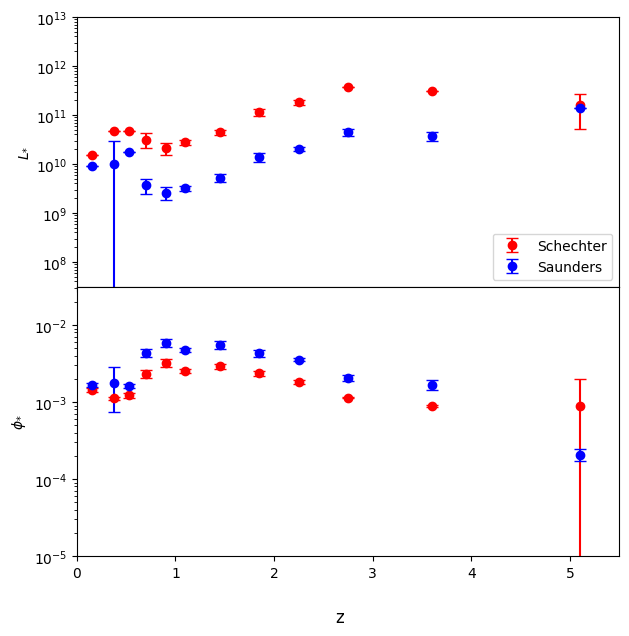

In [137]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='red', label='Schechter' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='blue', label='Saunders' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)
ax[0].set_ylim(10**7.5, 10**13)
ax[1].set_ylim(10**-5, 10**-1.5)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

### Class Evolution

C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\3747050798.py:2: RuntimeWarning: invalid value encountered in scalar power
  return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)
C:\Users\n10480129\AppData\Local\Temp\ipykernel_20864\3747050798.py:2: RuntimeWarning: invalid value encountered in log10
  return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)


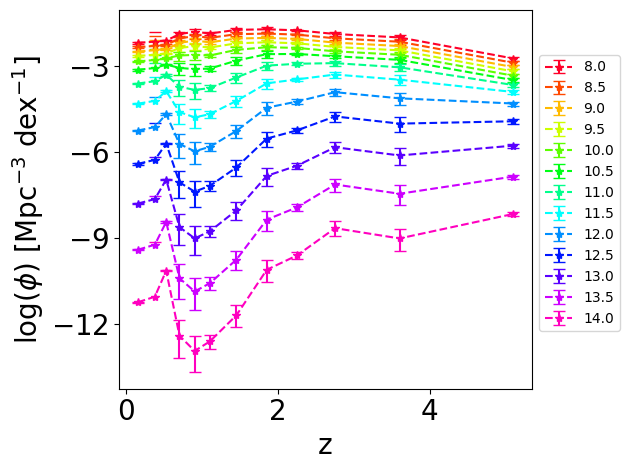

In [138]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_classes = np.arange(8, 14.5, 0.5)
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_classes)))
from matplotlib.ticker import FuncFormatter

def custom_log_formatter(val, pos):
    # Convert the logarithmic value to an exponent
    exponent = int(np.log10(val))
    return f'${exponent}$'

class_phi = []
for lc in luminosity_classes:
    lum_phi = []
    for params, perr in zip(saunder_params, saunder_error):
    # for params, perr in zip(schecter_params, schecter_errors):
        if params[0] is None:
            lum_phi.append([np.nan, np.nan, np.nan])
            continue
        phis = saunders_luminosity(10**lc, *params)
        phi_up = saunders_luminosity(10**lc, *(params+perr))
        phi_down = saunders_luminosity(10**lc, *(params-perr))
        # phis = schechter_luminosity(10**lc, *params)
        # phi_up = schechter_luminosity(10**lc, *(params+perr))
        # phi_down = schechter_luminosity(10**lc, *(params-perr))
        lum_phi.append([phis, phi_up-phis, phis-phi_down])
    class_phi.append(lum_phi)

for lc, lclass, c in zip(luminosity_classes, class_phi, colors):
    class_lum = np.array(lclass)
    phis = class_lum[:,0]
    phi_up = class_lum[:,1]
    phi_down = class_lum[:,2]
    plt.errorbar(redshift_centers, phis, yerr=[phi_down, phi_up], ls='--', capsize=4, marker='*', label=f'{lc}', color=c)
    
plt.legend(bbox_to_anchor=(1,0.9))
plt.xlabel('z', fontsize=20)
plt.yscale('log')
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.gca().yaxis.set_major_formatter(FuncFormatter(custom_log_formatter))
plt.tick_params(axis='both', labelsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('LF_classes.png', dpi=300)
plt.show()

### Export Data

In [112]:
file_name = 'CIGALE_TEST_AGN'
np.savez(file_name, 
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object), 
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(min_l, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object),
    schech_f=np.array(schechter_funcs, dtype=object),
    saunder_f=np.array(saunder_funcs, dtype=object))